<a href="https://colab.research.google.com/github/HSE-LAMBDA/mldm-2019/blob/master/day-7/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://github.com/yandexdataschool/MLatImperial2019/raw/master/06_lab/lfw_dataset.py

In [0]:
!pip install scipy==1.1

In [3]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [4]:
import numpy as np
import tensorflow as tf
tf.__version__

'2.0.0'

In [5]:
from lfw_dataset import fetch_lfw_dataset
data, _ = fetch_lfw_dataset(dimx=36, dimy=36)

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [6]:
data.shape

(13143, 36, 36, 3)

In [0]:
import matplotlib.pyplot as plt

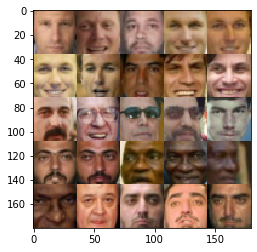

In [16]:
plt.imshow(data[:25].reshape(5, 5, 36, 36, 3).transpose((0, 2, 1, 3, 4)).reshape(5 * 36, 5 * 36, 3));

In [18]:
X_train = data.astype('float32') / 255
print(X_train.min(), X_train.max(), X_train.dtype)

0.0 1.0 float32


In [100]:
ll = tf.keras.layers

LATENT_DIM = 32

generator = tf.keras.Sequential([
  ll.Dense(32, input_shape=(LATENT_DIM,), activation='relu'),
  ll.Dense(64, activation='relu'),
  ll.Dense(36 * 36 * 3, activation='sigmoid'),
  ll.Reshape((36, 36, 3)),
])

discriminator = tf.keras.Sequential([
  ll.Reshape((36 * 36 * 3,), input_shape=(36, 36, 3)),
  ll.Dense(64, activation='relu'),
  ll.Dropout(0.1),
  ll.Dense(32, activation='relu'),
  ll.Dropout(0.1),
  ll.Dense(1),
])

generator.summary()
discriminator.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_109 (Dense)            (None, 64)                2112      
_________________________________________________________________
dense_110 (Dense)            (None, 3888)              252720    
_________________________________________________________________
reshape_37 (Reshape)         (None, 36, 36, 3)         0         
Total params: 255,888
Trainable params: 255,888
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_38 (Reshape)         (None, 3888)              0         
________________________

In [0]:
def gen_images(num):
  return generator(tf.random.normal(shape=(num, LATENT_DIM)))

# @tf.function decorator below compiles the function
# it decorates into a static graph. This improves the performance
# but there are some pitfalls one should be aware of when using it,
# check out https://www.tensorflow.org/tutorials/customization/performance
# for more details
@tf.function
def forward(batch):
  real = batch
  fake = gen_images(len(batch))

  shape = (len(batch), 1)
  #labels_real = tf.ones (shape=shape)
  labels_real = tf.cast(
      tf.random.uniform(shape=shape) > 0.1,
      'float32'
  )
  labels_fake = tf.zeros(shape=shape)

  X = tf.concat([real, fake], axis=0)
  y = tf.concat([labels_real, labels_fake], axis=0)

  loss = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(y, discriminator(X) + tf.random.normal(y.shape, stddev=0.05))
  )
  return loss

opt_d = tf.optimizers.RMSprop()
opt_g = tf.optimizers.RMSprop()

@tf.function
def disc_step(batch):
  with tf.GradientTape() as t:
    d_loss = forward(batch)
  grads = t.gradient(d_loss, discriminator.trainable_variables)
  opt_d.apply_gradients(zip(grads, discriminator.trainable_variables))
  return d_loss

@tf.function
def gen_step(batch):
  with tf.GradientTape() as t:
    g_loss = -forward(batch)
  grads = t.gradient(g_loss, generator.trainable_variables)
  opt_g.apply_gradients(zip(grads, generator.trainable_variables))
  return g_loss


In [0]:
from IPython.display import clear_output
from tqdm import trange

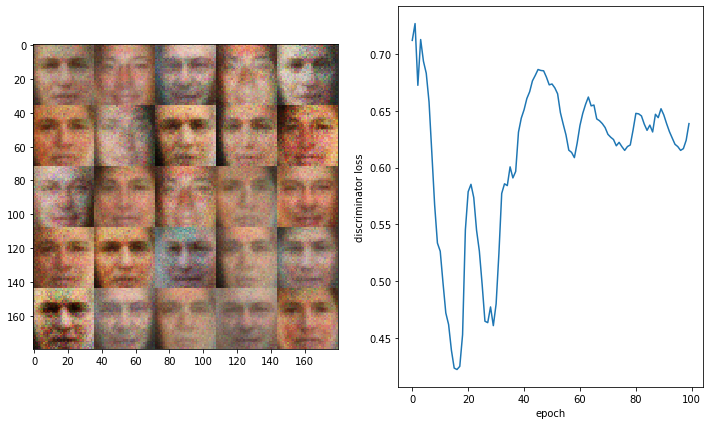

Done with epoch # 99


In [104]:
BATCH_SIZE = 256

N_EPOCHS = 100
NUM_DISC_STEPS = 5

i_disc_step = 0
losses = []
for i_ep in range(N_EPOCHS):
  shuffle_ids = np.random.choice(len(X_train), len(X_train), replace=False)
  epoch_loss = 0
  for i_img in trange(0, len(X_train), BATCH_SIZE):
    batch = X_train[shuffle_ids][i_img:i_img + BATCH_SIZE]

    if i_disc_step < NUM_DISC_STEPS:
      # discriminator update
      i_disc_step += 1
      epoch_loss += disc_step(batch).numpy() * len(batch)
    else:
      i_disc_step = 0
      epoch_loss -= gen_step(batch).numpy() * len(batch)

  epoch_loss /= len(X_train)
  losses.append(epoch_loss)

  opt_d.learning_rate.assign(opt_d.learning_rate * 0.99)
  opt_g.learning_rate.assign(opt_g.learning_rate * 0.99)

  imgs = (gen_images(25).numpy() * 255).astype('uint8')
  clear_output(wait=True)
  plt.figure(figsize=(12, 7))
  plt.subplot(1, 2, 1)
  plt.imshow(imgs.reshape((5, 5, 36, 36, 3)).transpose(0, 2, 1, 3, 4).reshape(36 * 5, 36 * 5, 3))
  plt.subplot(1, 2, 2)
  plt.plot(losses)
  plt.xlabel('epoch')
  plt.ylabel('discriminator loss')
  plt.show()
  print("Done with epoch #", i_ep)

## Excersizes

### 1. Implement a GAN with convolutional layers

### 2. Implement a Wasserstein GAN